<a href="https://colab.research.google.com/github/Hamza-Ali0237/CIFAR10-Web_App/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Main Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam

## Loading The Dataset

In [14]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualising The Data

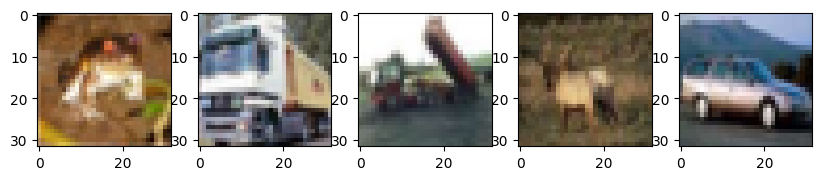

In [15]:
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
plt.show()

### Normalizing the data

In [16]:
X_train, X_test = X_train/255. , X_test/255.

### One-hot Encoding

In [17]:
num_classes = 10

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [18]:
# Display dataset shapes
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating Model (ResNet50)

In [19]:
res_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
    )

for layer in res_model.layers:
  layer.trainable = False

In [20]:
x = res_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=res_model.input, outputs=output)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Training The Model

In [22]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=50)

Epoch 1/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6357 - accuracy: 0.4153 - val_loss: 1.6712 - val_accuracy: 0.4075
Epoch 2/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6334 - accuracy: 0.4182 - val_loss: 1.5859 - val_accuracy: 0.4352
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6309 - accuracy: 0.4159 - val_loss: 1.6115 - val_accuracy: 0.4291
Epoch 4/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.6202 - accuracy: 0.4192 - val_loss: 1.6147 - val_accuracy: 0.4287
Epoch 5/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.6242 - accuracy: 0.4215 - val_loss: 1.6075 - val_accuracy: 0.4209
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6173 - accuracy: 0.4248 - val_loss: 1.6887 - val_accuracy: 0.4055
Epoch 7/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.6182 - accuracy: 0.4229 - val_loss: 1.7064 -

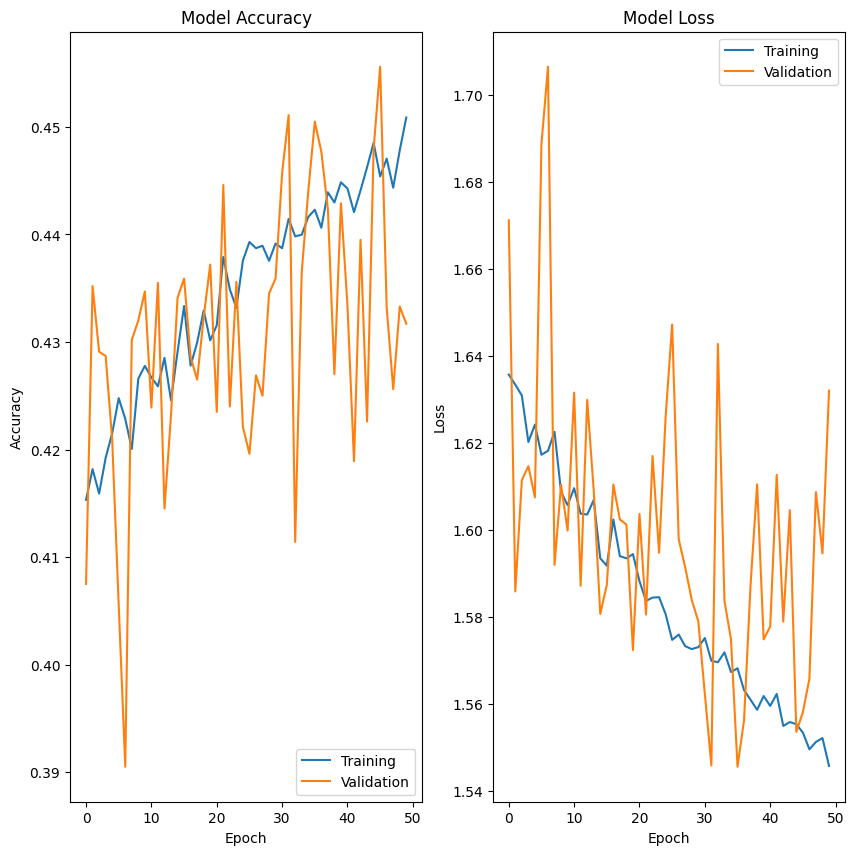

In [30]:
history = model.history
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()